                Open     High      Low     Close      Volume  Ex-Dividend  \
Date                                                                        
2004-08-19   100.010   104.06    95.96   100.335  44659000.0          0.0   
2004-08-20   101.010   109.08   100.50   108.310  22834300.0          0.0   
2004-08-23   110.760   113.48   109.05   109.400  18256100.0          0.0   
2004-08-24   111.240   111.60   103.57   104.870  15247300.0          0.0   
2004-08-25   104.760   108.00   103.88   106.000   9188600.0          0.0   
2004-08-26   104.950   107.95   104.66   107.910   7094800.0          0.0   
2004-08-27   108.100   108.62   105.69   106.150   6211700.0          0.0   
2004-08-30   105.280   105.49   102.01   102.010   5196700.0          0.0   
2004-08-31   102.320   103.71   102.16   102.370   4917800.0          0.0   
2004-09-01   102.700   102.97    99.67   100.250   9138200.0          0.0   
2004-09-02    99.090   102.37    98.94   101.510  15118600.0          0.0   

df after computed forecast:
                      Adj. Close  HL_PCT  PCT_Change  Adj. Volume  label  \
Date                                                                      
2017-10-15 05:30:00         NaN     NaN         NaN          NaN    NaN   
2017-10-16 05:30:00         NaN     NaN         NaN          NaN    NaN   
2017-10-17 05:30:00         NaN     NaN         NaN          NaN    NaN   
2017-10-18 05:30:00         NaN     NaN         NaN          NaN    NaN   
2017-10-19 05:30:00         NaN     NaN         NaN          NaN    NaN   

                        Forecast  
Date                              
2017-10-15 05:30:00   989.554419  
2017-10-16 05:30:00  1007.392332  
2017-10-17 05:30:00  1023.263726  
2017-10-18 05:30:00  1012.615549  
2017-10-19 05:30:00   987.936334  


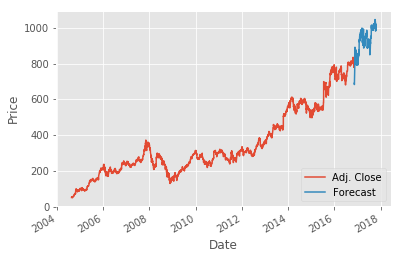

In [3]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, svm #, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

# Graph Style
style.use('ggplot')

# Get Google stock prices
df = quandl.get('WIKI/GOOGL')
print(df)

# Consider only interested features
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
print("Hand-picked columns of df head:\n", df.head())
print("Hand-picked columns of df tail:\n", df.tail())

# Compute Pct volatility and Pct Price change
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

# Consider only interested features
df =  df[['Adj. Close', 'HL_PCT', 'PCT_Change', 'Adj. Volume']]
print("Computed columns of df head:\n", df.head())
print("Computed columns of df tail:\n", df.tail())

df.fillna(-99999, inplace=True)
print("After FillNA - df head:\n", df.head())
print("After FillNA - df tail:\n", df.tail())
print("Length of dataframe = ", len(df))

# Calculate 10% of length of dataframe i.e. 10% of 1 year prices
forecast_out = int(math.ceil(0.1 * len(df)))
# No. of days in advance we can forecast
print("forecast_out (10% of dataframe) = ", forecast_out, " days")

forecast_col = 'Adj. Close'
df['label'] = df[forecast_col].shift(-forecast_out)
print("Fill Label Column with shifted values of df head:\n", df.head())
print("Fill Label Column with shifted values of df tail:\n", df.tail())


# Collect features from dataframe
X = np.array(df.drop(['label'], 1))  # drop column 'label' (as it is a feature) and convert dataframe to numpy array
X = preprocessing.scale(X) # Normalizes the data
X_lately = X[-forecast_out:] # Move 3082 to 3424 (= 343 rows) into X_lately for which we need to estimate close price
X = X[:-forecast_out] # Retain 1 to 3081 rows in X

df.dropna(inplace=True)
y = np.array(df['label'])  # Retain only column 'label'
print("Values of y:\n", y)

# Verify if the lengths of X, y are equal or not
print("Length of X = ", len(X), "\nLength of y = ", len(y))

# Split X, y into training and testing data
# test_size indicates use 20% of data as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Select the regression model i.e. Linear Regression
# optional parameter to is njobs i.e. LiearRegression(njobs); 
#   njobs = -1 indicates use as many threads as possible
#   njobs = 10 indicates use 10 threads, default is 1
# Note: We use the threads while training the model
# To change the regression to Support Vector Regression, clf = svm.SVR() i.e. uses 'linear' kernel 
#    or clf = svm.SVR(kernel='poly') i.e. 'polynomial' kernel
# We've to run following 4 lines first time and after we create the linearregression.pickle file,
# we can comment out the 4 lines to avoid the time consuming job each time
##clf = LinearRegression()

# Use X_train, y_train to fit ('fit' is synonymous to 'train the model') into the classifier
##clf.fit(X_train, y_train)

# Save the classifier to a file
##with open('lineraregression.pickle', 'wb') as f:
##    pickle.dump(clf, f)
    
pickle_in = open('lineraregression.pickle', 'rb')
clf = pickle.load(pickle_in)

# Use X_test, y_test to 'test the model ('score' is synonymous to 'test the model')
# Notice that we are using different data for 'training the model' and 'testing the model'; 
# if we use the same data used for training the model the accuracy will be perfect
accuracy = clf.score(X_test, y_test)
print('Accuracy of the model = \n', accuracy)

# Forecast logic
forecast_set = clf.predict(X_lately) # we can predict a single value or an array values
print(forecast_set, accuracy, forecast_out)

# Fill new Forecast column with nothing
df['Forecast'] = np.nan

# Prepare the next day date to the last unix date from existing stock price date
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

# Fill the next dates
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

print("df after computed forecast:\n", df.tail())

# Plot the current and estimated stock price values
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [4]:
print("Values of y:\n", y)


Values of y:
 [ 214.00561483  210.7254894   208.07229925 ... 1026.55       1054.09
 1006.94      ]
